In [ ]:
# this tuturial is from the fastmri github page and shows how to work with the fastmri dataset
# and data in the k-space domain

import h5py
import numpy as np
import matplotlib.pyplot as plt
from torch.fft import fft2, ifft2, fftshift, ifftshift

In [ ]:
# file_name = '../data/singlecoil_test/file1000022.h5'
file_name = '../data/multicoil_test/file1000295.h5'
hf = h5py.File(file_name)

In [ ]:
print(f'Keys: {list(hf.keys())}')
print(f'Attrs: {dict(hf.attrs)}')

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'acquisition': 'CORPD_FBK', 'num_low_frequency': 15, 'patient_id': '4c301aea1ce9746b7a95f23d84acc3e1d3caffbdee2a4e02997099370aedbc2b'}


In multi-coil MRIs, k-space has the following shape: (number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape: (number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [ ]:
volume_kspave = hf['kspace'][()]
print(volume_kspave.dtype)
print(volume_kspave.shape)

complex64
(38, 15, 640, 368)


In [ ]:
slice_kspace = volume_kspave[20]

In [ ]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i+1)
        plt.imshow(data[num], cmap=cmap)

/var/folders/5p/5z6fw3rd3cv3wr_xlglft0ch0000gn/T/ipykernel_18675/3999085860.py:2: RuntimeWarning: divide by zero encountered in log
  show_coils(np.log(np.abs(slice_kspace)), [0, 5, 10])


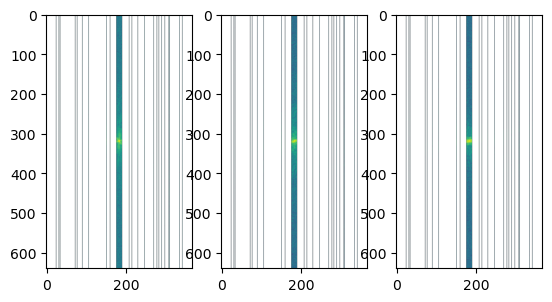

In [ ]:
# show_coils(np.log(np.abs(volume_kspave) + 1e-9), [0, 5, 10])
show_coils(np.log(np.abs(slice_kspace)), [0, 5, 10])

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [ ]:
import fastmri
from fastmri.data import transforms as T

In [ ]:
slice_kspace2 = T.to_tensor(slice_kspace)    # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)  # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)  # Compute absolute value to get a real image

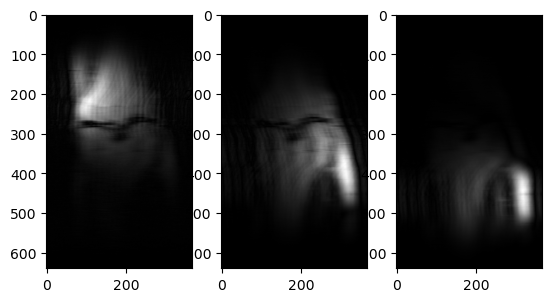

In [ ]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [ ]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

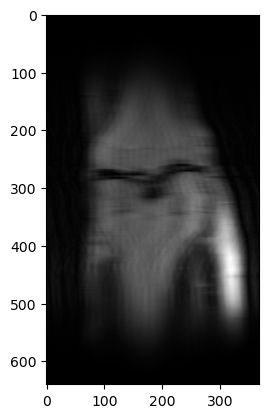

In [ ]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, data has been fully-sampled. We can simulate under-sampled data by creating a mask and applying it to k-space

In [ ]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8]) # Create the mask function

In [ ]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)  # Apply the mask to k-space

In [ ]:
# sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image = fftshift(fft2(ifftshift(masked_kspace, dim=(-2, -1)), dim=(-2,-1)))  # Apply fftshift to bring zero frequency to the center

sampled_image_abs = fastmri.complex_abs(sampled_image)  # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)  # Compute the root sum of squares to combine coils

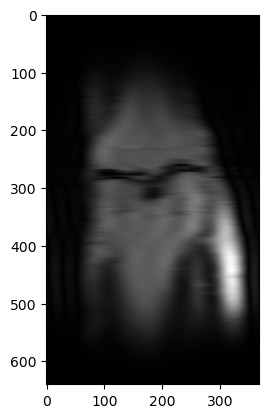

In [ ]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')